# Bedload intensity and morphological changes: there is a relation between them?
### Authors: Enrico Pandrin
### Tags: #PiQs, #DoD, #MAW, #BAW

The aims of this script are:
1. Produce overlapping maps of the mein measures taken in the lab. In particular:
    a. Overlap the ***bedload activity map***, the ***DoD*** and the ***DEM*** as boolena map to define the spatial relation between them. In particular to investigate the blind areas where sediment transport occurs but morphological changes are not detected.
    b. Look at the overlapping keeping the signal intensity, so have a rough idea about the relationship between bedload intensity and morphological changes intensity.
2. Perform analysis on the overlapped data to investigate the relations between morphological changes, bed elevation end bedload activity


In [1]:
# IMPORT LIBRARIES
import os
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from PIL import Image
import cv2
import tifffile as tiff

from functions import *

from scipy.stats import gaussian_kde

import PyPDF2
from PyPDF2 import PdfFileMerger, PdfFileReader, PdfFileWriter


In [2]:
# SETUP FOLDERS
home_dir    = os.getcwd() # Home directory
report_dir  = os.path.join(home_dir, 'output')
run_dir     = os.path.join(home_dir, 'surveys')
DoDs_folder = os.path.join(home_dir, 'DoDs', 'DoDs_stack') # Input folder

In [3]:
# SETUP RUNS

run_names = ['q07r1','q07r2','q07r3','q07r4','q07r5','q07r6','q07r7','q07r8','q07r9'
        ,'q10r1','q10r2','q10r3','q10r4','q10r5','q10r6','q10r7','q10r8','q10r9'
        ,'q15r1','q15r2','q15r3','q15r4','q15r5','q15r6','q15r7','q15r8','q15r9'
        ,'q20r1','q20r2','q20r3','q20r4','q20r5','q20r6','q20r7','q20r8','q20r9']
set_names = ['q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1'
        ,'q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2'
        ,'q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2'
        ,'q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2']

# run_names = ['q07r1']
# set_names = ['q07_1']

# run_names = ['q07r1','q07r2','q07r3','q07r4','q07r5','q07r6','q07r7','q07r8','q07r9']
# set_names = ['q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1','q07_1']

# run_names = ['q10r1','q10r2','q10r3','q10r4','q10r5','q10r6','q10r7','q10r8','q10r9']
# set_names = ['q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2','q10_2']

# run_names = ['q15r1','q15r2','q15r3','q15r4','q15r5','q15r6','q15r7','q15r8','q15r9']
# set_names = ['q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2','q15_2']

# run_names = ['q20r1','q20r2','q20r3','q20r4','q20r5','q20r6','q20r7','q20r8','q20r9']
# set_names = ['q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2','q20_2']

# run_names = ['q20r1']
# set_names = ['q20_2']

# 1. Data overlapping to visually check if any matches are visible
To do so, first of all we import all the data:
1. stack: the DoD stack (9,148,279,9) where the values are the magnitude of scour and deposition
2. evnBAA: the BAA envelope (700,6295) that is the envelope off al the BAAmaps and where the value is the number of times a pixel has been active
3. env_BAA_act_cmltv: the BAA envelope intensity (700. 6259) that is the cumulative envelope of the bedload intensity signal


    

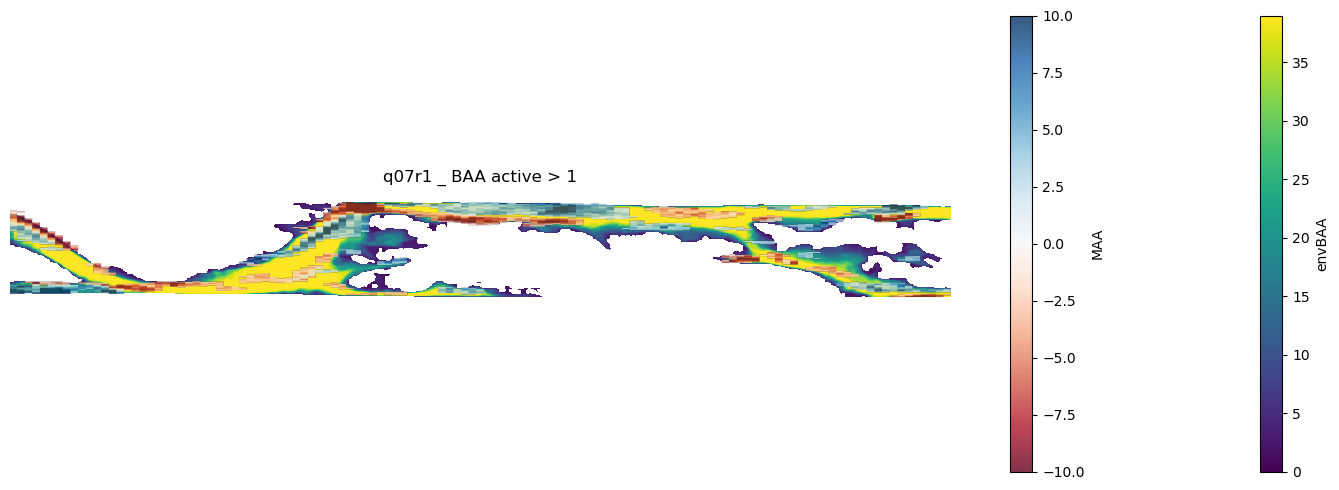

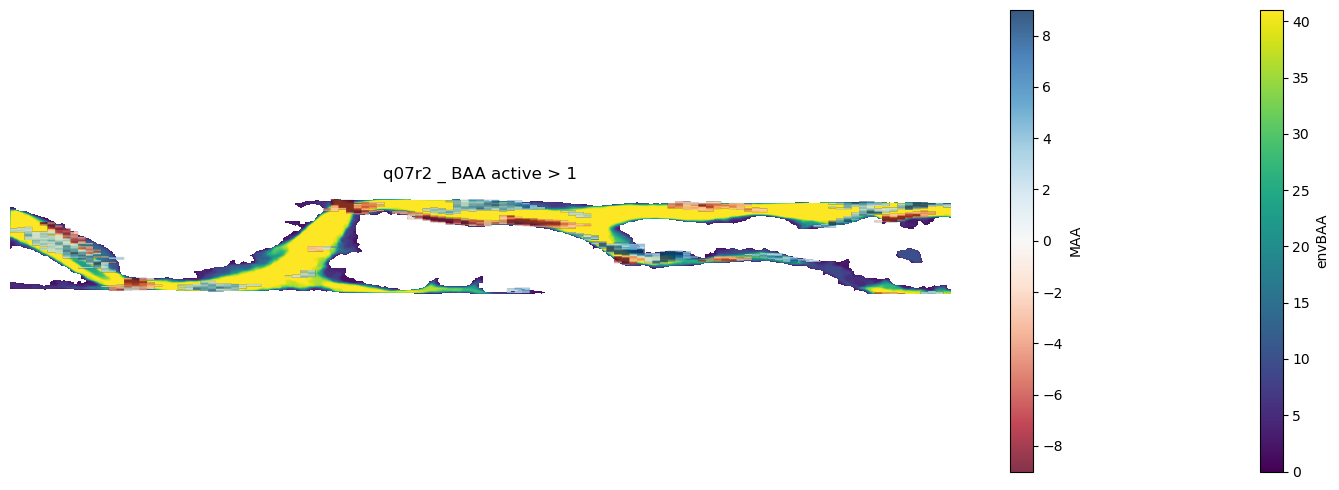

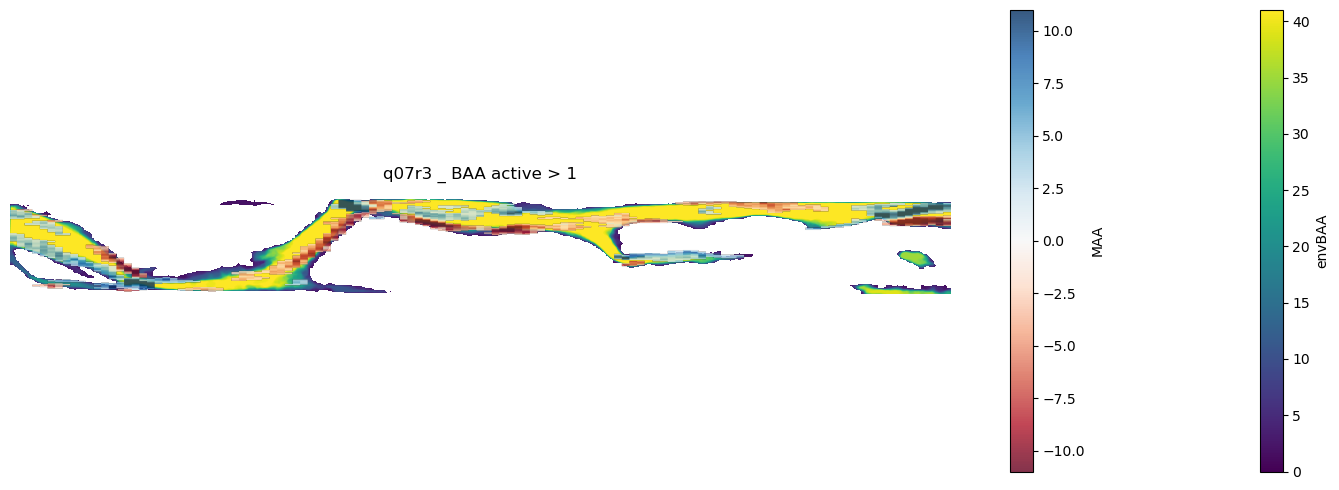

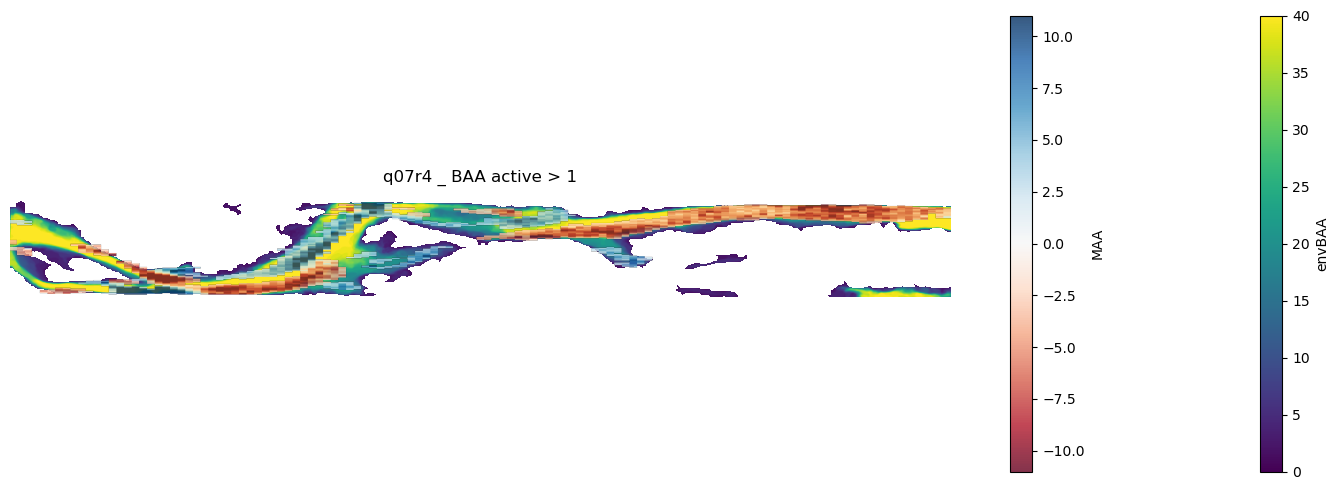

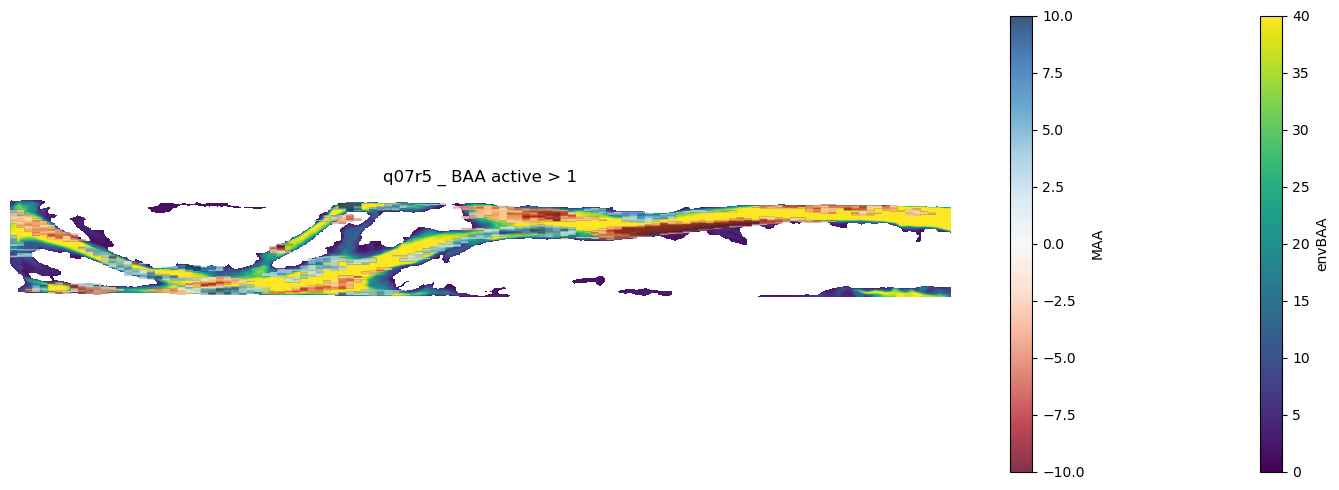

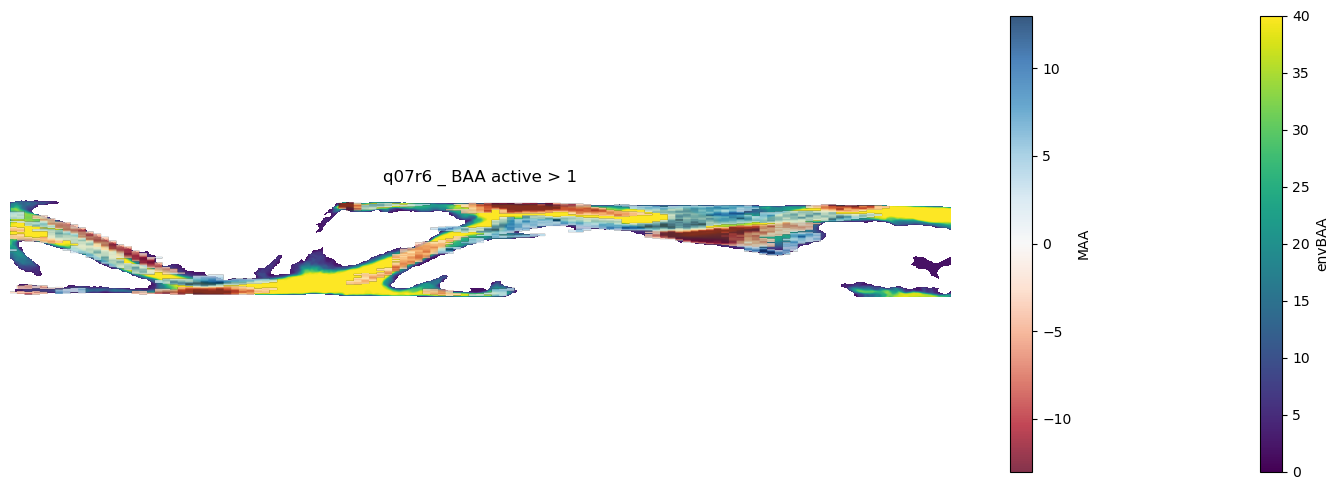

In [13]:
# DEFINE THE LIST OF ANALYSIS TO PERFORM:
analysis_list = ['1', '2']


# INITIALIZE THE COUNTERS
index = 0
nn=0

# LOOP ALL OVER THE RUNS
for run_name, set_name in zip(run_names, set_names):
    nn+=1

    # IMPORT THE LASER SURVEY MASK
    if True:
        runs_list = ['q10_1', 'q10_2', 'q15_1', 'q20_1', 'q20_2'] # Old runs with old ScanArea
        mask_arr_name, mask_arr_path = 'array_mask.txt', home_dir # Mask for runs 07 onwards

        if run_name in runs_list:
            mask_arr_name, mask_arr_path = 'array_mask_0.txt', home_dir
            
        # Load mask
        mask_arr = np.loadtxt(os.path.join(mask_arr_path, mask_arr_name))
        mask_arr_rsz = np.where(mask_arr==-999, np.nan, 1) # Convert in mask with 0 and 1
        mask_arr_rsz = np.repeat(mask_arr_rsz, 10, axis=1) # Rescale the envMAA (dx/dy = 10) (at this stage 144x2790)

    # IMPORT MAA STACK AND DoD BOOL STACK FROM DoD
    stack_name = 'DoD_stack' + '_' + set_name + '.npy' # Define stack name
    stack_bool_name = 'DoD_stack' + '_bool_' + set_name + '.npy' # Define stack bool name
    stack_path = os.path.join(DoDs_folder,stack_name) # Define stack path
    stack_bool_path = os.path.join(DoDs_folder,stack_bool_name) # Define stack bool path
    # LOAD THE STACK 
    stack = np.load(stack_path) # Load DoDs stack
    stack_bool = np.load(stack_bool_path) # Load DoDs bool stack
    
    # DEFINE THE STACK DIMENSIONS
    dim_t, dim_y, dim_x, dim_delta = stack.shape # Define time dimension, crosswise dimension and longitudinal dimension
    
    # EXTRACT THE MAA FROM THE MAA STACK
    envMAA = stack[index,:,:, 0] # (at this stage 144x279)
    envMAA_arr_plot = np.where(np.isnan(envMAA), 0, envMAA)
    envMAA_rsz = np.repeat(envMAA_arr_plot, 10, axis=1) # Rescale the envMAA (dx/dy = 10) (at this stage 144x2790)

    # CREATE THE BOOLEAN MAP OF THE MAA ENVELOPE
    envMAA_bool_rsz = np.where(np.logical_and(envMAA_rsz>0, np.logical_not(np.isnan(envMAA_rsz))), 1,0)

    # IMPORT BAA envelope:
    env_BAA_path = '/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/'+run_name+'/'+run_name+'_envBAA_map_activ_history.tiff'
    envBAA = Image.open(env_BAA_path)
    envBAA = np.array(envBAA)
    
    # IMPORT BAA CUMULATIVE ENVELOPE
    env_BAA_act_cmltv_path = os.path.join('/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/', run_name, run_name + '_envBAA_act_cumulative.tiff')
    env_BAA_act_cmltv = Image.open(env_BAA_act_cmltv_path)
    env_BAA_act_cmltv = np.array(env_BAA_act_cmltv)

    # Import a DEM
    DEM = np.loadtxt('/home/erri/Documents/PhD/Research/5_research_repos/DoD_analysis/surveys/q07_1/matrix_bed_norm_q07_1s0.txt', skiprows=8)
    DEM = np.where(DEM==-999, np.nan, DEM) # (at this stage 178x278)
    DEM_rsz = np.repeat(DEM, 10, axis=1) # Rescale the DEM (dx/dy = 10) (at this stage 144x2790)

    # RESAMPLE THE BAA DATA TO FIT WITH THE TOPOGRAPHIC SURVEY RESOLUTION
    kernel_size = 5
    envBAA_rsz = non_overlapping_average(envBAA, kernel_size)
    env_BAA_act_cmltv_rsz = non_overlapping_average(env_BAA_act_cmltv, kernel_size)

    # CREATE BOOLEAN MAPS WHERE ONLY PIXEL THAT HAS BEEN ACTIVE FOR LESS THAN act_thrs are zero, to the others 1 value is assigned
    env_act_thrs = 1
    envBAA_bool_rsz = np.where(envBAA_rsz>env_act_thrs,1,0).astype(np.uint8)


    # SCALE AND TRANSLATE  THE BAA DATA TO FIT THE TOPOGRAPHIC SURVEY IN THE CHARTS
    if True: # Define the roto-scale-translation parameters for each runs
        if set_name == 'q07_1':
            # Define the transformation parameters
            scale = 1.0 # Enlargement scale
            dx = 0 # Shift in x direction
            dy = 10 # Shift in y direction
            rot_angle = -0.55

        if set_name == 'q10_2':
            # Define the transformation parameters
            scale = 1.0 # Enlargement scale
            dx = 0 # Shift in x direction
            dy = 8 # Shift in y direction
            rot_angle = -0.3

        if set_name == 'q15_2':
            # Define the transformation parameters
            scale = 1.0 # Enlargement scale
            dx = 0 # Shift in x direction
            dy = 8 # Shift in y direction
            rot_angle = -0.4

        if set_name == 'q20_2':
            # Define the transformation parameters
            scale = 1.0 # Enlargement scale
            dx = -10 # Shift in x direction
            dy =8 # Shift in y direction
            rot_angle = -0.3
    
    # PERFORM THE SCALING
    envBAA_rsz_rsc = img_scaling_to_DEM(envBAA_rsz, scale, dx, dy, rot_angle) # envBAA resized, rescaled and rotated
    envBAA_bool_rsz_rsc = img_scaling_to_DEM(envBAA_bool_rsz, scale, dx, dy, rot_angle) # envBAA resized, rescaled and rotated
    env_BAA_act_cmltv_rsz_rsc = img_scaling_to_DEM(env_BAA_act_cmltv_rsz, scale, dx, dy, rot_angle) # envBAA resized, rescaled and rotated

    # CUT LASER OUTPUT BECAUSE ARE METERS LONGER THAN THE BAA MAPS
    envMAA_rsz = envMAA_rsz[:, envMAA_rsz.shape[1]-1229:]
    envMAA_bool_rsz = envMAA_bool_rsz[:, envMAA_bool_rsz.shape[1]-1229:]
    DEM_rsz = DEM_rsz[:, DEM_rsz.shape[1]-1229:]
    mask_arr_rsz = mask_arr_rsz[:, mask_arr_rsz.shape[1]-1229:]
    
    # APPLY TOPOGRAPHIC SURVEYS MAPS
    DEM_rsz = DEM_rsz*mask_arr_rsz # Apply mask

    # MAKE THE MATRIX WITH THE SAME SIZE TO BETTER PLOT THEM
    envBAA_rsz_rsc, envMAA_rsz = cut_matrices_to_minimum_dimension(envBAA_rsz_rsc, envMAA_rsz)
    
    # SAVE THE OUTPUTS TO BE OPENED WITH QGIS:
    np.savetxt('/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/'+run_name+'/'+run_name+'_envBAA_rsz_rsc.csv', envBAA_rsz_rsc, fmt='%.2f', delimiter=',')
    np.savetxt('/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/'+run_name+'/'+run_name+'_envMAA_rsz.csv', envMAA_rsz, fmt='%.2f', delimiter=',')

    tiff.imsave('/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/'+run_name+'/'+run_name+'_envBAA_rsz_rsc.tiff', envBAA_rsz_rsc)
    tiff.imsave('/home/erri/Documents/PhD/Research/5_research_repos/PiQs_analysis/Maps/'+run_name+'/'+run_name+'_envMAA_rsz.tiff', envMAA_rsz)


    if '1' in analysis_list:

        # PLOT MAPS OVERLAPPED
        plt.figure(figsize=(15, 5))
        # channel_background = plt.imshow(channel_rsz_rsc, alpha=1.0)
        envBAA = plt.imshow(np.where(envBAA_rsz_rsc<=1, np.nan, envBAA_rsz_rsc), cmap='viridis', alpha=1.0, vmin=0, vmax=int(np.max(envBAA_rsz_rsc)))
        plt.colorbar(envBAA, label='envBAA')
        envMAA_bool = plt.imshow(np.where(envMAA_rsz==0, np.nan, envMAA_rsz), cmap='RdBu', origin='upper', alpha=0.8, interpolation_stage='rgba', vmin=-int(np.percentile(abs(envMAA_rsz), 99)), vmax=int(np.percentile(abs(envMAA_rsz), 99)))
        plt.colorbar(envMAA_bool, label='MAA')
        # DEM = plt.imshow(np.where(np.isnan(DEM_rsz), np.nan, DEM_rsz), cmap='gist_earth', origin='upper', alpha=1.0, interpolation_stage='rgba', vmin=-20, vmax=20)
        # Set title and show the plot

        plt.title(run_name + ' _ BAA active > 1')
        plt.axis('off')
        plt.savefig(os.path.join(report_dir, set_name,
                    run_name + '_BAA_MAA.pdf'), dpi=600)

        if index == 0:
            plt.savefig(os.path.join(report_dir, set_name,
                        set_name + '_report_BAA_MAA.pdf'), dpi=1200)

        if nn == 1:
            plt.savefig(os.path.join(report_dir, 'report_BAA_MAA.pdf'), dpi=1200)
        plt.tight_layout()
        plt.show()

        # SAVE ALL THE PLOTS IN A PDF REPORT
        if len(run_names)>1:
            if index > 0:
                merger = PyPDF2.PdfMerger()
        
                # Open and append the existing PDF
                with open(os.path.join(report_dir, set_name, set_name + '_report_BAA_MAA.pdf'), "rb") as existing_file:
                    merger.append(existing_file)
        
                # Open and append the new PDF chart
                with open(os.path.join(report_dir, set_name, run_name + '_BAA_MAA.pdf'), "rb") as chart_file:
                    merger.append(chart_file)
        
                # Save the merged PDF
                with open(os.path.join(report_dir, set_name, set_name + '_report_BAA_MAA.pdf'), "wb") as merged_file:
                    merger.write(merged_file)
                
            if set_names[index]==set_names[index+1]:
                index+=1
            elif set_names[index]!=set_names[index+1]:
                index=0
            else:
                pass
                    
            if nn>1:
                merger = PyPDF2.PdfMerger()
        
                # Open and append the existing PDF
                with open(os.path.join(report_dir, 'report_BAA_MAA.pdf'), "rb") as existing_file:
                    merger.append(existing_file)
        
                # Open and append the new PDF chart
                with open(os.path.join(report_dir, set_name, run_name + '_BAA_MAA.pdf'), "rb") as chart_file:
                    merger.append(chart_file)
        
                # Save the merged PDF
                with open(os.path.join(report_dir, 'report_BAA_MAA.pdf'), "wb") as merged_file:
                    merger.write(merged_file)

    if '2' in analysis_list:
        '''
        Data to plot:
        envBAA_rsz_rsc
        envMAA_rsz
        '''
        matrix1 = np.where(envBAA_rsz_rsc==0, np.nan, envBAA_rsz_rsc)
        matrix2 = np.where(envMAA_rsz==0, np.nan, envMAA_rsz)

        def plot_matrices(matrix1_visible, matrix2_visible):
            plt.figure(figsize=(25, 5))
            
            # # Create a 1x2 grid of subplots
            # ax1 = plt.subplot(121)
            # ax2 = plt.subplot(122)

            # Get the shape of the matrices
            rows, cols = matrix1.shape
            
            # Define the extent based on the matrix shape
            extent = [0, 1229, 0, 140]

            # Plot the first matrix with specified alpha value to control visibility
            if matrix1_visible:
                matrix1_plot = plt.imshow(matrix1, cmap='viridis', alpha=1.0, extent=extent)
                # plt.colorbar(matrix1_plot, label='envBAA')
            
            # Plot the second matrix with specified alpha value to control visibility
            if matrix2_visible:
                matrix2_plot = plt.imshow(matrix2, cmap='RdBu', alpha=0.8, vmin=-30, vmax=+30, extent=extent)
                # plt.colorbar(matrix2_plot, label='envMAA')
            

            # cbar1 = plt.colorbar(label='envBAA', ax=plt.gca())

            # cbar2 = plt.colorbar(label='envMAA', ax=plt.gca())

            plt.title('Two Matrices as Layers')
            plt.tight_layout()
            # plt.colorbar()
            plt.show()

        matrix1_checkbox = widgets.Checkbox(value=True, description='envBAA')
        matrix2_checkbox = widgets.Checkbox(value=True, description='envMAA')

        output = widgets.interactive_output(plot_matrices,
                                            {'matrix1_visible': matrix1_checkbox,
                                            'matrix2_visible': matrix2_checkbox})

        display(widgets.VBox([matrix1_checkbox, matrix2_checkbox, output]))

In [ ]:
index = 0
nn=0
for run_name, set_name in zip(run_names, set_names):
#%%
    # Correlation analysis between BAA, DoD and DEM
    '''
    Data available:
        envMAA_rsz
        envBAA_rsz_rsc
        DEM_rsz
    '''
    # RESIZE ARRAYS:
    # Cut laser surveys rows
    envMAA_rsz = envMAA_rsz[:envBAA_rsz_rsc.shape[0],:]
    envMAA_bool_rsz = envMAA_bool_rsz[:envBAA_rsz_rsc.shape[0],:]
    DEM_rsz = DEM_rsz[:DEM_rsz.shape[0],:]
    
    # Cut images columns
    envBAA_rsz_rsc = envBAA_rsz_rsc[:,:envMAA_rsz.shape[1]]
    envBAA_bool_rsz_rsc = envBAA_bool_rsz_rsc[:,:envMAA_rsz.shape[1]]
    envBAA_act_cumulative_rsz_rsc = envBAA_act_cumulative_rsz_rsc[:,:envMAA_rsz.shape[1]]
    
    # With BAA cumulative map
    MAA_BAA_stack = np.stack((envMAA_rsz,envBAA_act_cumulative_rsz_rsc))
    
    # # With BAA number of ative times
    # MAA_BAA_stack = np.stack((envMAA_rsz,envBAA_rsz_rsc))
    
    
    # Unroll the stack and define a new array where the first row is MAA and
    # the second is BAA
    num_rows, num_slices, slice_length = MAA_BAA_stack.shape
    MAA_BAA_dataset = MAA_BAA_stack.reshape(num_rows, num_slices*slice_length)
    
    # Trim column where BAA is zero
    MAA_BAA_dataset_check = MAA_BAA_dataset[1] != 0
    MAA_BAA_dataset = MAA_BAA_dataset[:, MAA_BAA_dataset_check]
    
    if set_name == 'q07_1':
        c=4
    if set_name == 'q10_2':
        c=2
    if set_name == 'q15_2':
        c=2/3
    if set_name == 'q20_2':
        c=1
        
        
    # Create the scatter plot
    plt.scatter(MAA_BAA_dataset[0,:], MAA_BAA_dataset[1,:]/c, s=2, c='red', marker='o')
    '''
    Considering the cumulate values of the bedload activity could lead to a
    chart that is very difficult to read. In fact, given a costatn timespan
    between shoots the run duratio (that change a lot between runs) affects the
    envelope activity value.
    '''
    # Add labels and a title to the plot
    plt.xlabel('DoD value')
    plt.ylabel('Envelope cumulative value')
    plt.title(run_name + ' _ Scatter Plot')
    
    # Save image
    plt.savefig(os.path.join(report_dir, set_name, run_name + '_scatter_envBAA_cumulative_DoD'), dpi=400)
    
    # Show the plot
    plt.show()
    
    
    #%%
    '''
    Histograms with the distribution of frequency of the DoD and BAA cumulated values
    '''
    
    # MAA
    
    MAA_values = MAA_BAA_dataset[0,:]
    MAA_values = MAA_values[MAA_values != 0] # Trim zero values
    
    
    # Plot the histogram
    plt.hist(MAA_values, bins=np.arange(min(MAA_values), max(MAA_values) + 1), rwidth=0.6, align='left', density=True, alpha=0.6, label='Frequency')
    
    # Estimate the PDF using Kernel Density Estimation
    kde = gaussian_kde(MAA_values)
    x_vals = np.linspace(min(MAA_values), max(MAA_values), 1000)
    y_vals = kde(x_vals)
    
    # Plot the PDF on top of the histogram
    plt.plot(x_vals, y_vals, '-r', label='PDF')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Histogram with PDF - MAA_values')
    
    # Show a legend with the PDF label
    plt.legend()
    
    # Display the plot
    plt.show()
    
    
    
    # BAA
    
    BAA_values = MAA_BAA_dataset[1,:]/c
    BAA_values = BAA_values[BAA_values > 0] # Trim zero values
    
    # Plot the histogram
    plt.hist(BAA_values, bins=np.arange(min(BAA_values), max(BAA_values) + 1), rwidth=0.6, align='left', density=True, alpha=0.6, label='Frequency')
    
    # Estimate the PDF using Kernel Density Estimation
    kde = gaussian_kde(BAA_values)
    x_vals = np.linspace(min(BAA_values), max(BAA_values), 1000)
    y_vals = kde(x_vals)
    
    # Plot the PDF on top of the histogram
    plt.plot(x_vals, y_vals, '-r', label='PDF')
    
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Histogram with PDF - Bedload intensity cumulated values')
    
    # Show a legend with the PDF label
    plt.legend()
    
    # Display the plot
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Replace these matrices with your actual data
matrix1 = np.random.rand(10, 10)
matrix2 = np.random.rand(10, 10)

def plot_matrices(matrix1_visible, matrix2_visible):
    plt.figure(figsize=(10, 5))
    
    # Plot the first matrix with specified alpha value to control visibility
    if matrix1_visible:
        plt.imshow(matrix1, cmap='viridis', alpha=1.0)
    
    # Plot the second matrix with specified alpha value to control visibility
    if matrix2_visible:
        plt.imshow(matrix2, cmap='plasma', alpha=0.7)
    
    plt.title('Two Matrices as Layers')
    plt.colorbar()
    plt.show()

matrix1_checkbox = widgets.Checkbox(value=True, description='Show Matrix 1')
matrix2_checkbox = widgets.Checkbox(value=True, description='Show Matrix 2')

output = widgets.interactive_output(plot_matrices,
                                    {'matrix1_visible': matrix1_checkbox,
                                     'matrix2_visible': matrix2_checkbox})

display(widgets.VBox([matrix1_checkbox, matrix2_checkbox, output]))